# Marketing Campaign A/B Testing

## Table of Contents
1. [Introduction](#1)
2. [Power Analysis & Sampling](#2)
3. [Exploratory Data Analysis](#3)
4. [A/B Test](#4)
5. [Impact of No. of Advertisements Viewed on Conversion](#5)
6. [Optimal No. of Advertisements](#6)
7. [Temporal Impact of Advertisements Viewed on Customer Conversion](#7)
8. [Conclusion](#8)

# 1. Introduction <a id = '1'></a>

## Overview
In the digital marketing landscape, companies frequently implement new webpage designs, web elements, or advertisements to optimise key business metrics. However, determining the true impact of these marketing initiatives requires rigorous statistical testing to validate their effectiveness against existing practices. Using a [marketing dataset from Kaggle](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data), this analysis presents a business case study where we evaluate the effectiveness of a new advertisement campaign through A/B testing. The company aims to compare the conversion rates between two scenarios:

1. A new advertisement (experimental group)
2. The existing Public Service Announcement (PSA) as the control group

Both versions will be displayed in identical positions on the company's website, with visitors randomly assigned to either group. The primary success metric is customer conversion (purchase decision).

Beyond comparing overall effectiveness, the analysis delves deeper into whether the number of advertisement impressions affects conversion in the experimental group. Additionally, we examine how timing—specifically, the day of the week and hour of the day when ads are most frequently shown—influences the likelihood of customer conversion. Insights from this can help the company optimise advertisement placement strategy for improved return on investment (ROI).

## Research Objectives
This analysis seeks to address four key business questions:
1. Does the new advertisement campaign significantly improve customer conversion rates compared to the current PSA?
2. What is the impact of total advertisement exposure on conversion rates?
3. What is the optimal number of advertisements for conversion?
4. How do temporal factors (day of week and hour of day) influence conversion rates for customers who viewed advertisements?

## Key Metrics
- Primary Metric: Customer conversion rate ($Conversion \: Rate = \frac{Number \: of \: Conversions}{Total \: Number \: of \: Customers}$)
- Secondary Metrics:
  - Total number of advertisements viewed
  - Peak advertisement viewing day
  - Peak advertisement viewing hour

## Import Libraries

In [1]:
import os
import warnings

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import chi2_contingency, levene, mannwhitneyu, shapiro, skew
from statsmodels.formula.api import logit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize, proportions_ztest

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

# 2. Power Analysis & Sampling <a id = '2'></a>

In designing an effective A/B test, determining the appropriate sample size through power analysis is a critical first step that balances statistical rigour with practical constraints.

While larger sample sizes inherently provide more reliable results, businesses must optimise their experimentation process within finite resources and competing priorities. Power analysis helps determine the minimum sample size needed to achieve sufficient statistical confidence—specifically, the ability to correctly reject the null hypothesis ($H_0$) when it is indeed false—while ensuring the experiment duration and resource allocation remain practical and efficient.

This methodical approach to sample size determination helps companies avoid both underpowered studies that might miss real effects and overly lengthy experiments that inefficiently utilise resources.

In this experiment, our hypotheses are as follows:

> $H_0$: $p_1 = p_2$  
> $H_1$: $p_1 - p_2 < 0$  
> whereby $p_1$ is the conversion rate of the control group (PSA) and $p_2$ is that of the experiment group (advertisement).

First, we download the [dataset from Kaggle](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data) for our analysis and check if there are any nulls.

In [2]:
# Download datasets from Kaggle
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")
logger.info(f"Path to dataset files: {path}")
logger.info(f"Files in Kaggle directory: {os.listdir(path)}")

# Load dataset
marketing_df = pd.read_csv(os.path.join(path, "marketing_AB.csv"), index_col=0)
logger.success(f"Successfully loaded {' and '.join(os.listdir(path))}")

# Check if any nulls
logger.debug("Displaying dataframe info...")
marketing_df.info()
logger.info(f"Number of unique customers: {marketing_df['user id'].nunique():,}")

# Clean up column names
marketing_df.columns = marketing_df.columns.str.replace(" ", "_")

2025-05-11 23:46:07.369 | INFO     | __main__:<module>:3 - Path to dataset files: /Users/keithsngth/.cache/kagglehub/datasets/faviovaz/marketing-ab-testing/versions/1
2025-05-11 23:46:07.370 | INFO     | __main__:<module>:4 - Files in Kaggle directory: ['marketing_AB.csv']
2025-05-11 23:46:07.567 | SUCCESS  | __main__:<module>:8 - Successfully loaded marketing_AB.csv
2025-05-11 23:46:07.567 | DEBUG    | __main__:<module>:11 - Displaying dataframe info...
2025-05-11 23:46:07.608 | INFO     | __main__:<module>:13 - Number of unique customers: 588,101


<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


To properly design our A/B test, we need to consider three essential statistical parameters:
1. __Significance Level ($\alpha$)__: This is our threshold for determining when to reject the null hypothesis. It represents the acceptable probability of making a Type I error (false positive).
2. __Statistical Power__: This measures our test's ability to detect a true effect when one exists. Specifically, it's the probability that we'll correctly reject $H_0$ if it were false.
3. __Effect Size__: This quantifies how large of a difference we're trying to detect between our control and treatment groups.

Using these three parameters, we can work backwards to calculate the minimum sample size needed for a statistically valid test.
For this analysis, we're using standard statistical conventions:
1. A significance level of 5% ($\alpha$ = 0.05)
1. A statistical power of 80% (0.8)

A two-sample Z-test was chosen for our analysis as we are comparing conversion rates (proportions) between the control and treatment groups. This test is well-suited for comparing two independent proportions, especially with our large sample sizes.

To determine our effect size, we first need to establish our baseline conversion rate from the control group. We've set our minimum detectable effect (MDE) at 1%, meaning we want our test to be capable of identifying even a modest 1% improvement in conversion rates if the marketing team considers this a meaningful change.

In [3]:
# Calculate baseline conversion rates within control group
is_control_group_yes = marketing_df["test_group"] == "psa"
control_sample_df = marketing_df[is_control_group_yes]
effect_baseline = control_sample_df["converted"].mean()
logger.info(f"Baseline conversion rate: {effect_baseline:.2%}")

2025-05-11 23:46:07.634 | INFO     | __main__:<module>:5 - Baseline conversion rate: 1.79%


Our baseline conversion rate stands at 1.79%. For this A/B test, we aim to identify a MDE of at least 1% uplift in conversion rates. Given that we're analysing proportional data (conversion rates), we will use Cohen's $h$ to quantify our effect size.

The formula for Cohen's $h$ is expressed as:
$h = 2(arcsin \sqrt{p_1} - arcsin \sqrt{p_2})$

In addition, as we are expecting an uplift in conversion rates, configure this as a one-sided test by setting our alternative hypothesis to "larger".

In [4]:
# Calculate effect size
effect_size = proportion_effectsize(effect_baseline, effect_baseline + 0.01)

# Calculate sample size required
power_analysis = NormalIndPower()
sample_size = round(
    power_analysis.solve_power(
        effect_size=abs(effect_size),  # effect size has to be positive
        power=0.8,
        alpha=0.05,
        alternative="larger",
    )
)
logger.info(
    f"Minimum sample size per group required for 80% statistical power: {sample_size}"
)

2025-05-11 23:46:07.642 | INFO     | __main__:<module>:14 - Minimum sample size per group required for 80% statistical power: 2728


Based on the power analysis results, we need at least 2,728 samples to achieve 80% statistical power - meaning we can be 80% confident in detecting a true effect when one exists (i.e., correctly rejecting the null hypothesis when it is indeed false).

With the minimum sample size determined, we will now proceed to draw our experimental samples from the dataset randomly for both the control and experiment group, simulating how we would conduct collect A/B test data in a real-world scenario.

In [5]:
# Craete sample for A/B test
ab_test_df = marketing_df.groupby("test_group").sample(n=sample_size, random_state=16)
logger.info(
    f"Successfully sampled {sample_size} rows for each group. Total sample size: {ab_test_df.shape[0]}"
)

2025-05-11 23:46:07.733 | INFO     | __main__:<module>:3 - Successfully sampled 2728 rows for each group. Total sample size: 5456


# 3. Exploratory Data Analysis <a id = '3'></a> 

To compare conversions between the control and experimental groups, we create a cross-tabulation of the number of customers who converted after being shown either the PSA or the advertisement.

In [6]:
# Create confusion matrix
pd.crosstab(index=ab_test_df["converted"], columns=ab_test_df["test_group"])

test_group,ad,psa
converted,,
False,2662,2680
True,66,48


Bar plots were generated to visualise both the total number of conversions and the conversion rate for each group. The data suggests that the experimental group exposed to advertisements had a slightly higher conversion rate compared to the control group that viewed the PSA by about 0.7%.

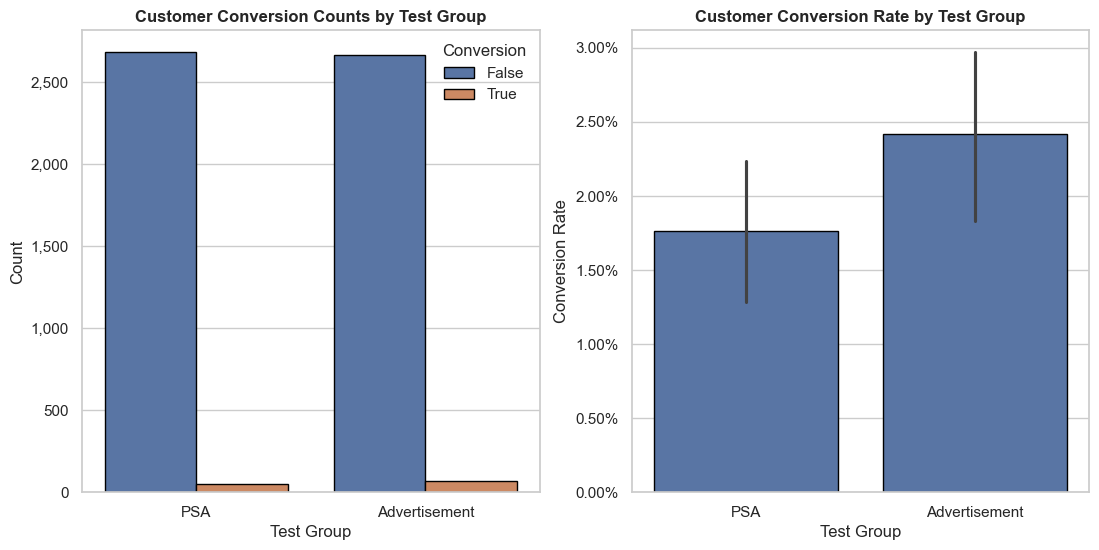

In [7]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

# Customer conversion counts by test group
sns.countplot(
    data=ab_test_df,
    x="test_group",
    hue="converted",
    order=["psa", "ad"],
    legend=True,
    edgecolor="black",
    ax=ax[0],
)
ax[0].set_title("Customer Conversion Counts by Test Group", fontweight="bold")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Test Group")
ax[0].set_xticks(np.arange(2), ["PSA", "Advertisement"])
ax[0].legend(title="Conversion", frameon=False)
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Customer conversion rate by test group
sns.barplot(
    data=ab_test_df,
    x="test_group",
    y="converted",
    order=["psa", "ad"],
    edgecolor="black",
    errorbar=("ci", 95),
    ax=ax[1],
)
ax[1].set_title("Customer Conversion Rate by Test Group", fontweight="bold")
ax[1].set_ylabel("Conversion Rate")
ax[1].set_xlabel("Test Group")
ax[1].set_xticks(np.arange(2), ["PSA", "Advertisement"])
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:,.2f}%"))

plt.show()

# 4. Two-Sample Z-Test <a id = '4'></a> 

To assess whether the observed increase in conversion rate is statistically significant or simply due to chance, we perform a two-sample Z-test for proportions.

The Z-test for two independent proportions relies on several assumptions as follows.
1.	__Independence of Observations__:
The observations within and between the two groups must be independent. In this context, we assume that customers assigned to either the PSA or advertisement group made their purchase decisions independently.

2.	__Random Assignment__: To minimise selection bias, individuals need to be randomly assigned to the control (PSA) and treatment (advertisement) groups. For this analysis, we assume that random assignment was performed for data collection.

3.	__Binary Outcome Variable__: The variable being measured must be categorical with only two possible outcomes: whether a customer converted (1) or did not convert (0).

4.	__Approximate Normality of Sampling Distribution__: While the population distributions are unknown, the sample sizes (both $n = 2728$) are sufficiently large. By the Central Limit Theorem (CLT), the sampling distribution of the sample proportions will approximate normality. Furthermore, both $np \geq 10$ and $n(1 - p) \geq 10$ hold true, which further justifies the normal approximation required for the Z-test.

5.	__Estimatable Standard Error__: Although the population standard deviations are not known, they can be estimated from the sample data. The Z-test relies on the normality of the sampling distribution and calculates the standard error using a pooled estimate of the sample proportions.

To recap, we defined our hypotheses as:
> $H_0$: $p_1 = p_2$ (no difference in conversion rates)  
> $H_1$: $p_1 < p_2$ (conversion rate for the experimental group is higher)  
> whereby $p_1$ refers to the conversion rate of the control group (PSA), and $p_2$ to that of the experimental group (advertisement).

We shall use a significance level of 5% for the above one-tailed test. Since we expect the experimental group to outperform the control group, our alternative hypothesis is that $p_1 < p_2$. In the *statsmodels* implementation of *proportions_ztest*, this corresponds to specifying `alternative="smaller"`, where the first proportion in the input list ($p_1$) is hypothesised to be less than the second ($p_2$).

In [8]:
# Split data into control and test groups
is_control_group_yes = ab_test_df["test_group"] == "psa"
is_test_group_yes = ab_test_df["test_group"] == "ad"

control_conversion = ab_test_df[is_control_group_yes]["converted"].sum()
test_conversion = ab_test_df[is_test_group_yes]["converted"].sum()

# Perform Z-test for proportions
ztest_statistic, ztest_p_value = proportions_ztest(
    count=[control_conversion, test_conversion],
    nobs=sample_size,
    alternative="smaller",  # refer to docs for definition of alternative one-tailed test
)

logger.info(f"Z statistic: {ztest_statistic:.2f}, p-value: {ztest_p_value:.4f}")

if ztest_p_value < 0.05:
    logger.success(
        "Reject the null hypothesis: the advertisement campaign was effective in increasing customer conversions significantly."
    )
else:
    logger.info(
        "Fail to reject the null hypothesis: the advertisement campaign was not effective in increasing customer conversions."
    )

2025-05-11 23:46:07.933 | INFO     | __main__:<module>:15 - Z statistic: -1.70, p-value: 0.0442
2025-05-11 23:46:07.934 | SUCCESS  | __main__:<module>:18 - Reject the null hypothesis: the advertisement campaign was effective in increasing customer conversions significantly.


Since our p-value < 0.05, the result is statistically significant, suggesting that the higher conversion rate observed in the advertisement test group is unlikely due to chance. This supports the hypothesis that advertisements can increase conversion rates and indicates the effectiveness of the marketing campaign.

# 5. Impact of No. of Advertisements Viewed on Conversion <a id = "5"></a>

Given that the initial findings indicate a statistically significant increase in conversion due to the new advertisement (though modest due to the MDE of 1%), we delve deeper into the relationship between the number of advertisements displayed and the temporal impact of their placement on conversion rates within the experimental group.

Specifically, we examine:
1.	Whether the total number of advertisements viewed influences the likelihood of customer conversion.
2.	Whether the day with the highest volume of advertisement impressions significantly affects conversion rates, and which specific day proves most effective.
3.	Whether the hour with the highest advertisement exposure correlates with increased conversions, and which hour yields the greatest impact.

First, we examine the impact of the total number of advertisements viewed on customer conversion.

In [9]:
# Filter for advertisement group
is_advertisement_yes = marketing_df["test_group"] == "ad"
ad_marketing_df = marketing_df[is_advertisement_yes]

We begin by visualising the distribution of customers by conversion status in relation to the number of advertisements viewed, paying particular attention to any skewness in the data.

Next, we assess whether the assumptions for conducting a parametric two-sample t-test are satisfied. The t-test is used to compare the mean number of advertisements viewed between converted and unconverted customers, and relies on the following assumptions:
1. Independence of observations
2. A continuous dependent variable (total number of advertisements viewed)
3. Data obtained through random sampling
4. Normal distribution of the dependent variable within each group (assessed using the Shapiro-Wilk test)
5. Equal variances across the two groups (assessed using Levene’s test)

Hypotheses for Levene’s test:
> $H_0$: The converted and unconverted groups have equal variance  
> $H_1$: The converted and unconverted groups have unequal variance

Hypotheses for the Shapiro-Wilk test:
> $H_0$: The data are normally distributed  
> $H_1$: The data are not normally distributed

In [10]:
# Create function to test normality
def test_normality(data: np.array) -> None:
    """Test normality of data using Shapiro-Wilk test.

    Args:
        data (np.array): Array of data to test for normality.
    """
    logger.debug(
        "Testing for normality... Conducting Shapiro-Wilk test and plotting QQ-plot."
    )

    # Shapiro-Wilk test
    statistic, p_value = shapiro(data)
    logger.info(f"Shapiro-Wilk test statistic: {statistic:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        logger.warning("Data is not normally distributed.")
    else:
        logger.success("Data is normally distributed.")

    # QQ-plot
    qqplot(data, line="s")
    plt.show()

2025-05-11 23:46:08.084 | INFO     | __main__:<module>:10 - Skewness of control group: 4.8891
2025-05-11 23:46:08.085 | INFO     | __main__:<module>:11 - Skewness of experiment group: 7.7052


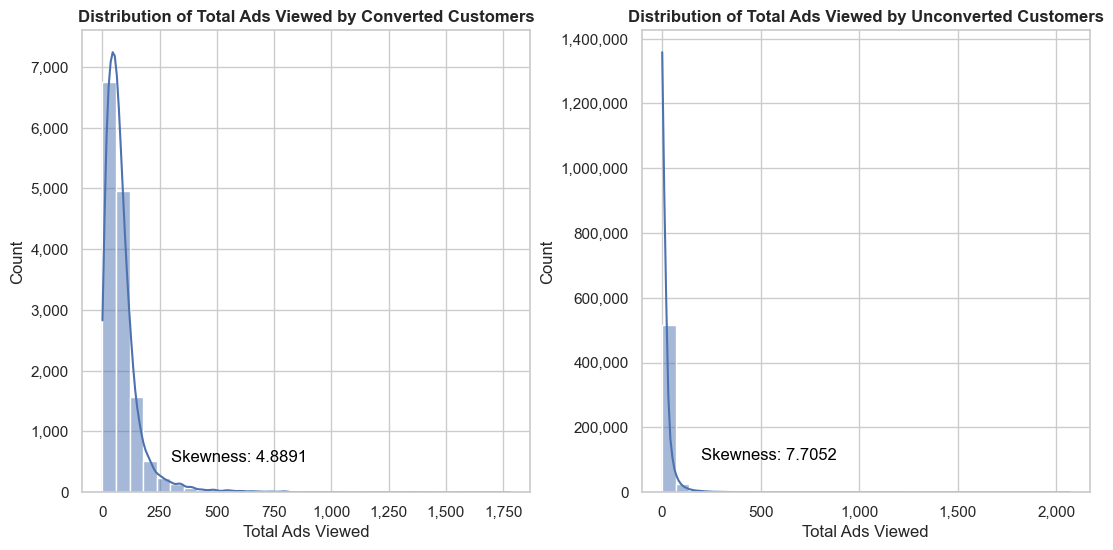

2025-05-11 23:46:08.807 | INFO     | __main__:<module>:45 - F-statistic: 8738.95, p-value: 0.0000
2025-05-11 23:46:08.808 | SUCCESS  | __main__:<module>:48 - Reject the null hypothesis: the variances of advertisements viewed by customers were converted and unconverted are significantly different.
2025-05-11 23:46:08.808 | DEBUG    | __main__:test_normality:8 - Testing for normality... Conducting Shapiro-Wilk test and plotting QQ-plot.
2025-05-11 23:46:08.820 | INFO     | __main__:test_normality:14 - Shapiro-Wilk test statistic: 0.4731, p-value: 0.0000
2025-05-11 23:46:08.820 | WARNING  | __main__:test_normality:16 - Data is not normally distributed.


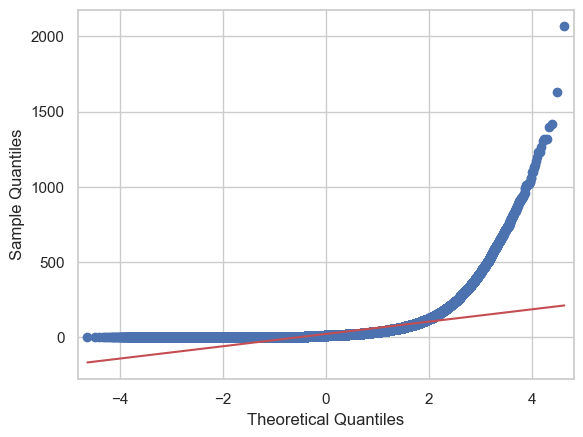

2025-05-11 23:46:09.186 | DEBUG    | __main__:test_normality:8 - Testing for normality... Conducting Shapiro-Wilk test and plotting QQ-plot.
2025-05-11 23:46:09.187 | INFO     | __main__:test_normality:14 - Shapiro-Wilk test statistic: 0.6537, p-value: 0.0000
2025-05-11 23:46:09.188 | WARNING  | __main__:test_normality:16 - Data is not normally distributed.


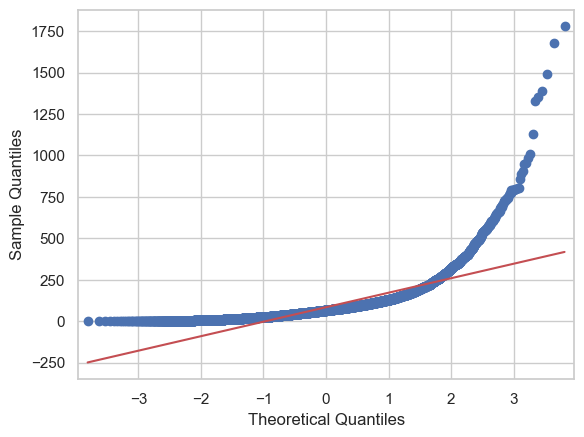

In [11]:
# Split into converted and unconverted customers
is_converted_yes = ad_marketing_df["converted"] == 1

ads_viewed_converted_yes = ad_marketing_df[is_converted_yes]["total_ads"]
ads_viewed_converted_no = ad_marketing_df[~is_converted_yes]["total_ads"]

# Calculate skew
skew_converted_yes = skew(ads_viewed_converted_yes)
skew_converted_no = skew(ads_viewed_converted_no)
logger.info(f"Skewness of control group: {skew_converted_yes:.4f}")
logger.info(f"Skewness of experiment group: {skew_converted_no:.4f}")

# Plot distributions of ads viewed
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

sns.histplot(ads_viewed_converted_yes, bins=30, kde=True, ax=ax[0])
ax[0].set_title(
    "Distribution of Total Ads Viewed by Converted Customers", fontweight="bold"
)
ax[0].text(300, 500, f"Skewness: {skew_converted_yes:.4f}", fontsize=12, color="black")
ax[0].set_xlabel("Total Ads Viewed")
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

sns.histplot(ads_viewed_converted_no, bins=30, kde=True, ax=ax[1])
ax[1].set_title(
    "Distribution of Total Ads Viewed by Unconverted Customers", fontweight="bold"
)
ax[1].text(
    200, 100000, f"Skewness: {skew_converted_no:.4f}", fontsize=12, color="black"
)
ax[1].set_xlabel("Total Ads Viewed")
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.subplots_adjust(wspace=0.25)
plt.show()

# Calculate Levene's test for equality of variance
f_statistic, levene_p_value = levene(
    ads_viewed_converted_yes,
    ads_viewed_converted_no,
)

logger.info(f"F-statistic: {f_statistic:.2f}, p-value: {levene_p_value:.4f}")

if levene_p_value < 0.05:
    logger.success(
        "Reject the null hypothesis: the variances of advertisements viewed by customers were converted and unconverted are significantly different."
    )
else:
    logger.info(
        "Fail to reject the null hypothesis: there is insufficient evidence to say that variances of ads viewed by customers were converted and unconverted are significantly different."
    )

test_normality(ads_viewed_converted_no)
test_normality(ads_viewed_converted_yes)

From the histogram plots, converted customers generally viewed more advertisements than unconverted ones. While both groups exhibit skewness, unconverted customers display a higher degree of right-skew (7.7052) compared to the converted group (4.8891). Furthermore, Levene’s test yields an F-statistic of 8,738.95 with a p-value of 0.00, indicating a statistically significant difference in variances between the two groups.

However, due to the violation of the normality assumption, as confirmed by the Shapiro-Wilk tests and QQ-plots, we are unable to proceed with a parametric t-test. Instead, we perform the Mann-Whitney U test, a non-parametric alternative that does not assume normality and is appropriate given the following:
1. Independence of observations
2. An ordinal or continuous dependent variable
3. An independent variable with two categories (converted vs unconverted)
4. Similar distribution shapes across the groups

Hypotheses for the Mann-Whitney U test:
> $H_0$: The distributions of advertisements viewed are the same for both groups  
>$H_1$: Converted users viewed more advertisements than those who did not (i.e., the distribution is shifted to the right)

In [12]:
# Conduct mann-whitney U test
mwu_statistic, mwu_p_value = mannwhitneyu(
    ads_viewed_converted_yes,
    ads_viewed_converted_no,
    alternative="greater",
)

logger.info(f"U statistic: {mwu_statistic:.2f}, p-value: {mwu_p_value:.4f}")
if mwu_p_value < 0.05:
    logger.success(
        "Reject the null hypothesis: the distribution of advertisements viewed by converted customers is greater than that of unconverted customers."
    )
else:
    logger.info(
        "Fail to reject the null hypothesis: there is no difference in the distributions viewdd by converted and unconverted customers."
    )

2025-05-11 23:46:09.281 | INFO     | __main__:<module>:8 - U statistic: 6788295318.50, p-value: 0.0000
2025-05-11 23:46:09.282 | SUCCESS  | __main__:<module>:10 - Reject the null hypothesis: the distribution of advertisements viewed by converted customers is greater than that of unconverted customers.


Since p-value < 0.05, we reject $H_0$ and conclude that users who converted tend to have viewed significantly more advertisements than those who did not (i.e., distribution of advertisements viewed for converted users is shifted to the right, indicating a higher tendency to convert with increased advertisement exposure). This result provide evidence that the number of advertisements shown positively influences conversion.

Hence, the next important question is: how many advertisements are sufficient to optimise conversion rates? The answer has direct implications for efficient allocation of marketing resources within the company. Estimating an optimal number of advertisements would allow the marketing team to maximise campaign effectiveness while minimising unnecessary spend, thereby freeing up resources for other strategic initiatives.

# 6. Optimal Number of Advertisements <a id = "6"></a>

To identify the optimal number of advertisements for maximising conversion efficiency, we perform a simple logistic regression to model the probability of conversion as a function of the number of advertisements viewed. The goal is to find the point, $x$, where the probability of conversion increases most rapidly (i.e., where the marginal return on additional advertisements is highest, corresponding to the maximum derivative of the logistic curve). This value of $x$ represents the number of advertisements at which an additional advertisement yields the greatest increase in conversion probability. Beyond this point, marginal gains begin to diminish, allowing the marketing team to evaluate whether further investment is justified based on available resources and ROI.

The logistic regression model is defined as: $P(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$  
The rate of change in conversion probability with respect to the number of advertisements is given by the derivative: $\frac{dP}{dx} = P(x) \cdot (1 - P(x)) \cdot \beta_1$, which is maximised when $P(x) = 0.5$  
Solving for $P(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} = 0.5$, we get $x = -\frac{\beta_0}{\beta_1}$

2025-05-11 23:46:09.291 | DEBUG    | __main__:<module>:4 - Fitting logistic regression model
2025-05-11 23:46:09.592 | SUCCESS  | __main__:<module>:6 - Logistic regression model successfully fitted


Optimization terminated successfully.
         Current function value: 0.110057
         Iterations 8


2025-05-11 23:46:10.232 | INFO     | __main__:<module>:7 - 
                            Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               564577
Model:                          Logit   Df Residuals:                   564575
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 May 2025   Pseudo R-squ.:                 0.07440
Time:                        23:46:10   Log-Likelihood:                -62136.
converged:                       True   LL-Null:                       -67130.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0422      0.010   -396.309      0.000      -4.062      -4.022
total_ads      0.0102      0.000    101.089      0.000       0.010    

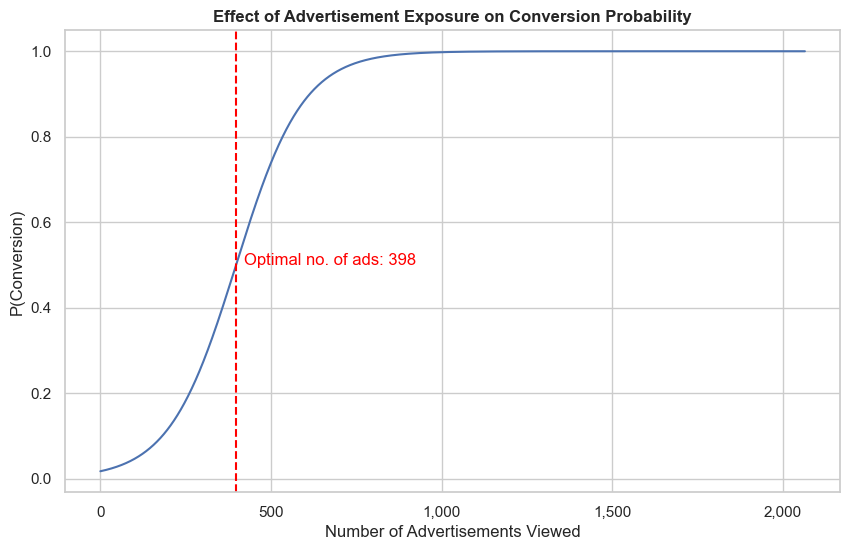

In [13]:
# Fit logistic regression model
ad_marketing_df["converted"] = ad_marketing_df["converted"].astype(int)

logger.debug("Fitting logistic regression model")
lr_model = logit("converted ~ total_ads", data=ad_marketing_df).fit()
logger.success("Logistic regression model successfully fitted")
logger.info(f"\n {lr_model.summary()}")

# Predict conversion probabilities for each value of X
ads_range_grid_df = pd.DataFrame(
    {"total_ads": np.arange(0, max(ad_marketing_df["total_ads"]) + 1)}
)
conversion_probs = lr_model.predict(ads_range_grid_df)

# Calculate optimal number of advertisements where conversiion probability increases most rapidly (i.e., point of diminishing marginal returns)
beta_0 = lr_model.params["Intercept"]
beta_1 = lr_model.params["total_ads"]
optimal_ads = -beta_0 / beta_1
logger.info(
    f"Number of advertisements where conversion probability increases most rapidly: {optimal_ads:.0f}"
)

# Plot conversion probabilities
plt.figure(figsize=(10, 6))

sns.lineplot(x=ads_range_grid_df["total_ads"], y=conversion_probs)
plt.xlabel("Number of Advertisements Viewed")
plt.ylabel("P(Conversion)")
plt.title(
    "Effect of Advertisement Exposure on Conversion Probability",
    fontweight="bold",
)
plt.axvline(x=optimal_ads, color="red", linestyle="--")
plt.text(420, 0.5, f"Optimal no. of ads: {optimal_ads:.0f}", fontsize=12, color="red")
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()

Based on our analysis, the optimal number of advertisements is 398. Beyond this point, additional advertisements yield diminishing marginal returns in conversion probability. Thus, this value $x = 398$ serves as a strategic baseline for the marketing team to assess whether further investment in the campaign is justified, especially if the goal is to push the average conversion probability above 0.5.

Alternatively, if the team has a specific target conversion probability, $P(x) = p$, we can also solve the logistic regression equation to determine the corresponding value of $x$. This enables data-driven planning, allowing the marketing team to align campaign intensity with acceptable performance targets and budget constraints.

# 7. Temporal Impact of Advertisements Viewed on Customer Conversion <a id = "7"></a>

In this section, we conduct further analysis to examine whether temporal factors, specifically the day of the week and hour of the day, influence conversion rates. Understanding these patterns can provide valuable insights for optimising marketing strategies and timing campaigns to maximise conversions.

First, we visualise the trends by inspecting bar charts that show how conversion rates vary based on the day with the most advertisements viewed and the hour with the most advertisements viewed. This exploratory step helps identify potential temporal patterns in user behaviour.

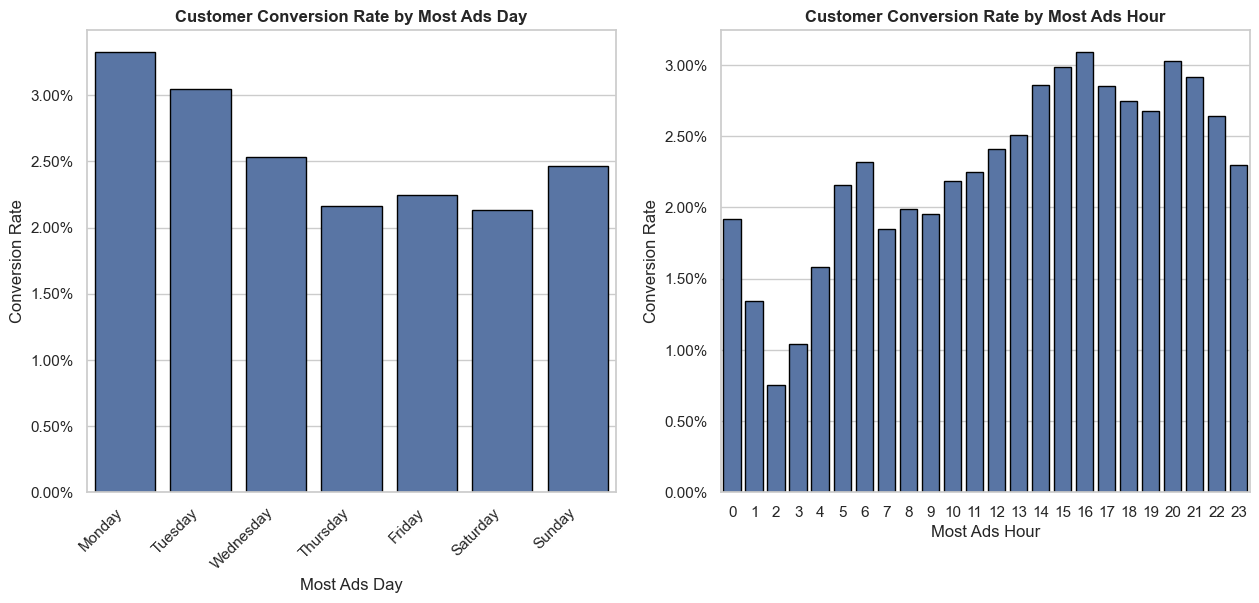

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Customer conversion by most ads day
sns.barplot(
    data=ad_marketing_df.groupby(["most_ads_day"]).agg(
        conversion_rate=("converted", "mean")
    ),
    x="most_ads_day",
    y="conversion_rate",
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    edgecolor="black",
    ax=ax[0],
)
ax[0].set_title("Customer Conversion Rate by Most Ads Day", fontweight="bold")
ax[0].set_ylabel("Conversion Rate")
ax[0].set_xlabel("Most Ads Day")
ax[0].set_xticks(
    np.arange(7),
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=45,
    ha="right",
)
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:,.2f}%"))

# Customer conversion by most ads hour
sns.barplot(
    data=ad_marketing_df.groupby(["most_ads_hour"]).agg(
        conversion_rate=("converted", "mean")
    ),
    x="most_ads_hour",
    y="conversion_rate",
    edgecolor="black",
    ax=ax[1],
)
ax[1].set_title("Customer Conversion Rate by Most Ads Hour", fontweight="bold")
ax[1].set_ylabel("Conversion Rate")
ax[1].set_xlabel("Most Ads Hour")
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:,.2f}%"))

plt.show()

Based on the graphs above, there are clear differences in conversion rates across both the day of the week and the hour of the day with the most advertisements viewed. For example, conversion rates are highest on Mondays and Tuesdays, suggesting that early-week exposure may be more effective. Similarly, peak conversions occur at 15:00, 16:00, and 20:00 (i.e., 3PM, 4PM, and 8PM), indicating specific hours where users are more likely to convert.

To statistically validate the observed relationships between conversion rates and these temporal factors, we perform Chi-square tests of independence for each pair of variables:
- `converted` vs. `most_ads_day`
- `converted` vs. `most_ads_hour`

This will help determine whether the observed variations are statistically significant or likely due to chance.

## 7.1. Most Ads Day

We begin by testing whether there is a significant association between conversion outcome and day with the most advertisements viewed through a Chi-square test.

Chi-square test assumptions:
1. Both variables are categorical
2. Observations are independent
3. Expected frequencies in each cell of the contingency table are at least 5
4. Data obtained by random sampling

Our hypotheses are as follows:
> $H_0$: There is no association between the day of most advertisements viewed and conversion outcome  
> $H_1$: There is an association between the day of most advertisements viewed and conversion outcome

In [15]:
# Create a contingency table
contingency_table = pd.crosstab(
    ad_marketing_df["converted"], ad_marketing_df["most_ads_day"]
)

# Display contingency table
logger.info(f"Contingency table: \n{contingency_table}")

# Run chi-square test
chisq_statistic, chisq_p_value, dof, expected = chi2_contingency(contingency_table)

logger.info(
    f"Chi-square statistic: {chisq_statistic:.2f}, p-value: {chisq_p_value:.4f}"
)

if (expected < 5).any():
    logger.info(
        "Chi-square test is not valid because expected frequencies are less than 5."
    )

if (expected >= 5).any():
    if chisq_p_value < 0.05:
        logger.success(
            "Reject the null hypothesis: there is an association between the day of most advertisements viewed and conversion outcome."
        )
    else:
        logger.info(
            "Fail to reject the null hypothesis: there is no association between the day of most advertisements viewed and conversion outcome."
        )

2025-05-11 23:46:10.566 | INFO     | __main__:<module>:7 - Contingency table: 
most_ads_day  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
converted                                                                   
0              86810   80793     77123   80305     77366    72302      75455
1               1995    2778      1679    2027      1711     2270       1963
2025-05-11 23:46:10.567 | INFO     | __main__:<module>:12 - Chi-square statistic: 412.79, p-value: 0.0000
2025-05-11 23:46:10.567 | SUCCESS  | __main__:<module>:23 - Reject the null hypothesis: there is an association between the day of most advertisements viewed and conversion outcome.


Since the Chi-square test yielded a p-value less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant association between conversion rate and the day of the week with the most advertisements viewed.

To further explore this relationship, we will fit a logistic regression model to estimate the probability of conversion based on the day of most advertisements viewed. This allows us to quantify how conversion likelihood varies across different days of the week, helping the marketing team strategically schedule advertisement placements on days associated with higher conversion probabilities and thereby maximising campaign effectiveness.

Logistic regression models typically take the first category of the response variable as the baseline for the intercept (e.g., Monday). To ensure that we can quantify the effect of each day of the week, the logistic regression model will be fitted with $intercept = 0$.

In [16]:
# Convert most_ads_day to categorical and reorder categories by day of week
ad_marketing_df["most_ads_day"] = (
    ad_marketing_df["most_ads_day"]
    .astype("category")
    .cat.reorder_categories(
        [
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ],
        ordered=True,
    )
)

# Fit logistic regression model
logger.debug("Fitting logistic regression model")
lr_model = logit("converted ~ most_ads_day + 0", data=ad_marketing_df).fit()
logger.success("Logistic regression model successfully fitted")
logger.info(f"\n {lr_model.summary()}")

2025-05-11 23:46:10.592 | DEBUG    | __main__:<module>:20 - Fitting logistic regression model
2025-05-11 23:46:11.264 | SUCCESS  | __main__:<module>:22 - Logistic regression model successfully fitted


Optimization terminated successfully.
         Current function value: 0.118550
         Iterations 8


2025-05-11 23:46:11.915 | INFO     | __main__:<module>:23 - 
                            Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               564577
Model:                          Logit   Df Residuals:                   564570
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 May 2025   Pseudo R-squ.:                0.002973
Time:                        23:46:11   Log-Likelihood:                -66930.
converged:                       True   LL-Null:                       -67130.
Covariance Type:            nonrobust   LLR p-value:                 4.190e-83
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
most_ads_day[Monday]       -3.3702      0.019   -174.653      0.000      -3.408      -3.332
most_ads_day[Tuesday]      -3.

Generally, the model result indicates that conversion rates are highest when advertisements are viewed on Monday and Tuesday whereas conversion rates are lowest over the weekend on Saturday. Given that p-values are all less than 0.05, the results are statistically significant and are unlikely to be due to chance.

To make the results more intuitive, the log-odds coefficients were translated into predicted conversion probabilities. This allows us to compare days on a practical scale rather than in terms of log-odds.

In [17]:
# Get model coefficients
coefs = lr_model.params
pvalues = lr_model.pvalues

# Calculate predicted probabilities for each day
days = ad_marketing_df["most_ads_day"].cat.categories
probabilities = {}

for day in days:
    coef = coefs.get(f"most_ads_day[{day}]", 0)
    prob = 1 / (1 + np.exp(-coef))
    pvalue = pvalues.get(f"most_ads_day[{day}]", 0)
    probabilities[day] = [round(prob, 5), round(pvalue, 5)]

# Convert to dataframe
most_ads_day_probabilities_df = pd.DataFrame.from_dict(
    probabilities,
    orient="index",
    columns=["Predicted Conversion Probability", "P-Value"],
)

# Display results, sorted by predicted conversion probability in descending order
most_ads_day_probabilities_df.sort_values(
    "Predicted Conversion Probability", ascending=False
)

,Predicted Conversion Probability,P-Value
Monday,0.03324,0.0
Tuesday,0.03044,0.0
Wednesday,0.02536,0.0
Sunday,0.02462,0.0
Friday,0.02246,0.0
Thursday,0.02164,0.0
Saturday,0.02131,0.0


The analysis reveals that Monday has the highest predicted conversion probability, followed by Tuesday and Sunday. Saturday consistently exhibits the lowest conversion likelihood. From a business perspective, this information is highly actionable as the marketing team can better allocate resources to days that have better conversion performance or develop alternative strategies to further improve engagement on low conversion days to improve performance.

Overall, understanding how conversion likelihood varies by day of the week provides valuable insight for campaign planning as it allows the company to optimise advertisement scheduling and maximise marketing investment by prioritising high-performing time windows.

## 7.2. Most Ads Hour

Likewise, we first test whether there is an association between conversion outcome and the hour of highest advertisement viewings via a Chi-square test.

Our hypotheses are as follows:
> $H_0$: There is no association between the hour of most advertisements viewed and conversion outcome  
> $H_1$: There is an association between the hour of most advertisements viewed and conversion outcome

In [18]:
# Create a contingency table
contingency_table = pd.crosstab(
    ad_marketing_df["converted"], ad_marketing_df["most_ads_hour"]
)

# Display contingency table
logger.info(f"Contingency table: \n{contingency_table}")

# Run chi-square test
chisq_statistic, chisq_p_value, dof, expected = chi2_contingency(contingency_table)

logger.info(
    f"Chi-square statistic: {chisq_statistic:.2f}, p-value: {chisq_p_value:.4f}"
)

if (expected < 5).any():
    logger.info(
        "Chi-square test is not valid because expected frequencies are less than 5."
    )

if (expected >= 5).any():
    if chisq_p_value < 0.05:
        logger.success(
            "Reject the null hypothesis: there is an association between the hour of most advertisements viewed and conversion outcome."
        )
    else:
        logger.info(
            "Fail to reject the null hypothesis: there is no association between the hour of most advertisements viewed and conversion outcome."
        )

2025-05-11 23:46:11.999 | INFO     | __main__:<module>:7 - Contingency table: 
most_ads_hour    0     1     2     3    4    5     6     7      8      9   \
converted                                                                   
0              5207  4553  5113  2563  683  726  1939  6054  16631  29220   
1               102    62    39    27   11   16    46   114    337    582   

most_ads_hour     10     11     12     13     14     15     16     17     18  \
converted                                                                      
0              36636  43157  44146  44345  42528  41576  34852  32646  30199   
1                818    992   1092   1140   1251   1279   1111    959    853   

most_ads_hour     19     20     21     22     23  
converted                                         
0              28387  27003  28052  24840  19098  
1                782    843    843    675    449  
2025-05-11 23:46:11.999 | INFO     | __main__:<module>:12 - Chi-square statistic: 403.3

Given that p-value < 0.05, we reject the null hypothesis and conclude that there is a significant association between conversion outcome and the hour of most advertisement viewed.

We also fit a logistic regression model between conversion outcome and the hour of most advertisments viewed with an intercept of 0 to quantify the predicted conversion probability of each hour, and translate the log-odds coefficients to predicted probabilities for interpretability. 

In [19]:
# Convert to categorical
ad_marketing_df["most_ads_hour"] = ad_marketing_df["most_ads_hour"].astype("category")

# Fit logistic regression model
logger.debug("Fitting logistic regression model")
lr_model = logit("converted ~ most_ads_hour + 0", data=ad_marketing_df).fit()
logger.success("Logistic regression model successfully fitted")
logger.info(f"\n {lr_model.summary()}")

2025-05-11 23:46:12.012 | DEBUG    | __main__:<module>:5 - Fitting logistic regression model
2025-05-11 23:46:14.001 | SUCCESS  | __main__:<module>:7 - Logistic regression model successfully fitted


Optimization terminated successfully.
         Current function value: 0.118510
         Iterations 9


2025-05-11 23:46:14.602 | INFO     | __main__:<module>:8 - 
                            Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               564577
Model:                          Logit   Df Residuals:                   564553
Method:                           MLE   Df Model:                           23
Date:                Sun, 11 May 2025   Pseudo R-squ.:                0.003304
Time:                        23:46:14   Log-Likelihood:                -66908.
converged:                       True   LL-Null:                       -67130.
Covariance Type:            nonrobust   LLR p-value:                 1.795e-79
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
most_ads_hour[0]     -3.9328      0.100    -39.336      0.000      -4.129      -3.737
most_ads_hour[1]     -4.2964      0.128    -33.60

In [20]:
# Get model coefficients
coefs = lr_model.params
pvalues = lr_model.pvalues

# Get all hours and calculate predicted probabilities
hours = ad_marketing_df["most_ads_hour"].cat.categories
probabilities = {}

for hour in hours:
    coef = coefs.get(f"most_ads_hour[{hour}]", 0)
    prob = 1 / (1 + np.exp(-coef))
    pvalue = pvalues.get(f"most_ads_hour[{hour}]", 0)
    probabilities[hour] = [round(prob, 5), round(pvalue, 5)]

# Convert to DataFrame
most_ads_hour_probabilities_df = pd.DataFrame.from_dict(
    probabilities,
    orient="index",
    columns=["Predicted Conversion Probability", "P-Value"],
)

# Display top 5, sorted by predicted conversion probability in descending order
most_ads_hour_probabilities_df.sort_values(
    "Predicted Conversion Probability", ascending=False
).nlargest(n=5, columns="Predicted Conversion Probability")

,Predicted Conversion Probability,P-Value
16,0.03089,0.0
20,0.03027,0.0
15,0.02984,0.0
21,0.02917,0.0
14,0.02858,0.0


From the model results, the top five hours with the highest predicted conversion rates are 14:00 (2PM), 15:00 (3PM), 16:00 (4PM), 20:00 (8PM), and 21:00 (9PM). These findings suggest that users are more likely to engage during mid-afternoon and evening hours, potentially due to browsing habits during afternoon breaks or post-dinner downtime, compared to less active periods such as early mornings or standard working hours.

These insights can help the company optimise the timing of advertisement placements throughout the day to maximise ROI and improve the overall effectiveness of its marketing strategy.

# 8. Conclusion <a id = '8'></a> 

In this project, we analysed a company’s marketing data to evaluate and optimise its advertising strategy using power analysis, A/B testing, statistical tests, and logistic regression. We also assessed how the number of advertisements viewed and temporal factors, such as day of the week and time of day, affect conversion rates. These analyses provided concrete benchmarks for the marketing team, such as the optimal number of advertisement exposures and the most effective time slots for advertisement placement to maximise conversion.

Although the study primarily employed basic statistical methods, including simple logistic regression models, the results offer actionable insights. However, future analyses could be strengthened by incorporating richer customer-level data (e.g., demographic data such as annual income, marital status, gender, etc.) and developing more complex models to improve predictive performance, especially given the low pseudo-$R^2$ values observed. Further validation through metrics such as accuracy and F1-score would also help ensure robustness.

Overall, by combining statistical testing with exploratory visualisations, the project supports data-driven decision making that reinforces and sharpens the marketing strategy, ultimately driving better business outcomes.